In [1]:
import os
import pandas as pd

# File Location
main_dir = '.'
all_data = []

strain_variants = ['true strain', 'tstrain', 'Tstrain', ]
stress_variants = ['true stress', 'tstress', 'stress']

for folder in sorted(os.listdir(main_dir)):
    folder_path = os.path.join(main_dir, folder)
    if os.path.isdir(folder_path) and folder.endswith("C"):
        print(f"\nProcessing folder: {folder}")
        temperature = folder.replace("C", "")

        for file in os.listdir(folder_path):
            if file.endswith(".xls") or file.endswith(".xlsx"):
                file_path = os.path.join(folder_path, file)
                try:
                    df = pd.read_excel(file_path)
                    print(f"Columns in {file}: {df.columns.tolist()}")

                    
                    df.columns = df.columns.str.strip()

                    
                    col_map = {col.lower(): col for col in df.columns}

                    
                    strain_col = next((col_map[k] for k in strain_variants if k in col_map), None)
                    stress_col = next((col_map[k] for k in stress_variants if k in col_map), None)

                    if strain_col and stress_col:
                        temp_df = df[[strain_col, stress_col]].copy()
                        temp_df.columns = ['True Strain', 'True Stress']

                        
                        temp_df = temp_df[(temp_df['True Strain'] > 0) & (temp_df['True Stress'] > 0)]
                        temp_df.dropna(inplace=True)

                        
                        delimiter = '-' if '-' in file else ('_' if '_' in file else None)
                        if delimiter:
                            try:
                                strain_rate_part = file.split(delimiter)[1].replace(".xls", "").replace(".xlsx", "")
                                if strain_rate_part.replace('.', '').isdigit():
                                    strain_rate = float(strain_rate_part)
                                else:
                                    print(f"Invalid strain rate: {file}. Skipping...")
                                    continue
                            except IndexError:
                                print(f"Could not extract strain rate: {file}. Skipping...")
                                continue
                        else:
                            print(f"Unknown filename: {file}. Skipping...")
                            continue

                        # Add metadata
                        temp_df['Temperature (C)'] = int(temperature)
                        temp_df['Strain Rate (1/s)'] = strain_rate

                        all_data.append(temp_df)
                    else:
                        print(f"Missing data in: {file} - Found: {df.columns.tolist()}")
                except Exception as e:
                    print(f"Error processing file {file}: {e}")

# Merge and export
if all_data:
    df_processed = pd.concat(all_data, ignore_index=True)
    df_processed.to_csv('cleaned_flow_stress_data.csv', index=False)
    print("\nData loaded and saved to 'cleaned_flow_stress_data.csv'")
    print(df_processed.head())
else:
    print("\nNo data extracted. Please check column names in your files.")



Processing folder: 100C
Columns in 100-0.0001.xls: ['Disp', 'Load', 'Unnamed: 2', 'E Strain', 'E Stress', 'Unnamed: 5', 'True strain', 'True Stress', 'Unnamed: 8', 'Plastic strain', 'True Stress.1']
Columns in 100-0.01.xls: ['Disp', 'Load', 'Unnamed: 2', 'E Strain ', 'E Stress', 'Unnamed: 5', 'True Strain', 'True Stress', 'Unnamed: 8', 'Plastic Strain', 'True Stress.1']
Columns in 100-0.1.xls: ['Disp', 'Load', 'Unnamed: 2', 'E Strain', 'E Stress', 'Unnamed: 5', 'True Strain', 'True Stress', 'Unnamed: 8', 'Plastic Strain', 'True stress']
Columns in 100-0.001.xls: ['Disp', 'Load', 'Unnamed: 2', 'E strain', 'E Stress', 'Unnamed: 5', 'True Strain', 'True Stress', 'Unnamed: 8', 'Plastic Strain', 'True Stress.1']

Processing folder: 150C
Columns in 150-0.001.xls: ['Disp', 'Load', 'Unnamed: 2', 'E Strain', 'E Stress', 'Unnamed: 5', 'True Strain', 'True Stress', 'Unnamed: 8', 'Plastic Strain', 'True Stress.1']
Columns in 150-0.01.xls: ['Disp', 'Load', 'Unnamed: 2', 'E Strain', 'E Stress', 'Un

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv('cleaned_flow_stress_data.csv')
 
features_to_normalize = ['True Strain', 'True Stress']

# Initialization
scaler = MinMaxScaler()

# Apply normalization
df_normalized = df.copy()
df_normalized[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Save 
df_normalized.to_csv('normalized_flow_stress_data.csv', index=False)

print("Normalized data saved to 'normalized_flow_stress_data.csv'")
print(df_normalized.head())


Normalized data saved to 'normalized_flow_stress_data.csv'
   True Strain  True Stress  Temperature (C)  Strain Rate (1/s)
0     0.001061     0.019322              100             0.0001
1     0.001061     0.020613              100             0.0001
2     0.001061     0.021905              100             0.0001
3     0.001591     0.021913              100             0.0001
4     0.001591     0.023205              100             0.0001


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

#GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = df_processed[['True Strain', 'Strain Rate (1/s)', 'Temperature (C)']].values
y = df_processed['True Stress'].values.reshape(-1, 1)

X_scaler = StandardScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
validation_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval)):
    print(f"\nFold {fold + 1}")
    X_fold_train = torch.tensor(X_trainval[train_idx], dtype=torch.float32).to(device)
    y_fold_train = torch.tensor(y_trainval[train_idx], dtype=torch.float32).to(device)
    X_fold_val = torch.tensor(X_trainval[val_idx], dtype=torch.float32).to(device)
    y_fold_val = torch.tensor(y_trainval[val_idx], dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_fold_train, y_fold_train), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_fold_val, y_fold_val), batch_size=128, shuffle=False)

    model = ImprovedNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    best_loss = float('inf')
    patience_counter = 0
    model.train()

    with tqdm(total=150, desc=f"Epochs (Fold {fold + 1})", ncols=100) as pbar:
        for epoch in range(150):
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                preds = model(batch_X)
                loss = criterion(preds, batch_y)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    preds = model(batch_X)
                    val_loss += criterion(preds, batch_y).item()
            val_loss /= len(val_loader)
            scheduler.step(val_loss)
            model.train()
            pbar.update(1)

    print(f"Fold {fold + 1} Validation Loss: {val_loss:.6f}")
    validation_losses.append(val_loss)

final_model = ImprovedNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

X_trainval_tensor = torch.tensor(X_trainval, dtype=torch.float32).to(device)
y_trainval_tensor = torch.tensor(y_trainval, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(X_trainval_tensor, y_trainval_tensor), batch_size=32, shuffle=True)

final_model.train()
with tqdm(total=150, desc="Training Final Model", ncols=100) as pbar:
    for epoch in range(150):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            preds = final_model(batch_X)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step(loss.item())
        pbar.update(1)

Using device: cuda

Fold 1


Epochs (Fold 1): 100%|████████████████████████████████████████████| 150/150 [03:40<00:00,  1.47s/it]


Fold 1 Validation Loss: 0.001253

Fold 2


Epochs (Fold 2): 100%|████████████████████████████████████████████| 150/150 [03:38<00:00,  1.46s/it]


Fold 2 Validation Loss: 0.000713

Fold 3


Epochs (Fold 3): 100%|████████████████████████████████████████████| 150/150 [03:40<00:00,  1.47s/it]


Fold 3 Validation Loss: 0.001062

Fold 4


Epochs (Fold 4): 100%|████████████████████████████████████████████| 150/150 [03:38<00:00,  1.45s/it]


Fold 4 Validation Loss: 0.001104

Fold 5


Epochs (Fold 5): 100%|████████████████████████████████████████████| 150/150 [03:37<00:00,  1.45s/it]


Fold 5 Validation Loss: 0.001058


Training Final Model: 100%|███████████████████████████████████████| 150/150 [11:57<00:00,  4.78s/it]


In [67]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    y_test_actual = y_scaler.inverse_transform(y_test)
    test_preds = y_scaler.inverse_transform(test_preds)

mse = mean_squared_error(y_test_actual, test_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, test_preds)
r2 = r2_score(y_test_actual, test_preds)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

MSE:  820.8415
RMSE: 28.6503
MAE:  18.8875
R²:   0.9863


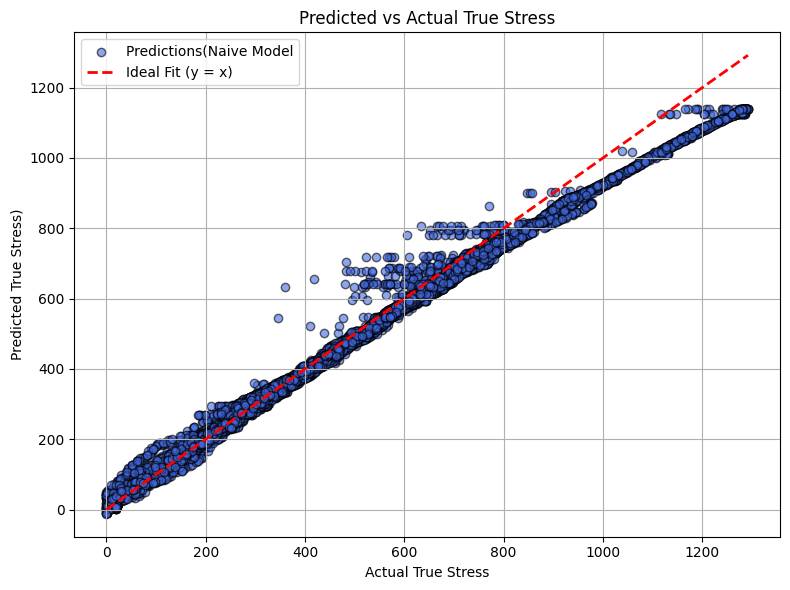

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, test_preds, alpha=0.6, color='royalblue', edgecolors='k', label='Predictions(Naive Model')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2, label='Ideal Fit (y = x)')
plt.xlabel("Actual True Stress")
plt.ylabel("Predicted True Stress)")
plt.title("Predicted vs Actual True Stress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Group data 
grouped = df_processed.groupby(['Temperature (C)', 'Strain Rate (1/s)'])

# Build 
sequences = []
for (temp, rate), group in grouped:
    group = group.sort_values(by='True Strain')
    strain = group['True Strain'].values
    stress = group['True Stress'].values
    max_idx = np.argmax(stress)
    
    stress[max_idx+1:] = 0
    
    temp_arr = np.full_like(strain, temp)
    rate_arr = np.full_like(strain, rate)
    
    sequence = np.stack([strain, rate_arr, temp_arr, stress], axis=1)
    sequences.append(sequence)

# Normalize 
all_data = np.concatenate(sequences, axis=0)
X_scaler = StandardScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(all_data[:, :3])
y_scaled = y_scaler.fit_transform(all_data[:, 3].reshape(-1, 1))

scaled_sequences = []
start = 0
for seq in sequences:
    length = len(seq)
    seq_X = X_scaled[start:start+length]
    seq_y = y_scaled[start:start+length]
    scaled_seq = np.hstack([seq_X, seq_y])
    scaled_sequences.append(scaled_seq)
    start += length

# Pad sequences
max_seq_len = max(len(seq) for seq in scaled_sequences)
def pad_sequence(seq, max_len):
    pad_len = max_len - len(seq)
    if pad_len > 0:
        pad = np.zeros((pad_len, 4))  # 3 inputs + 1 output
        return np.vstack([seq, pad])
    return seq

padded_data = np.stack([pad_sequence(seq, max_seq_len) for seq in scaled_sequences])
X_data = padded_data[:, :, :3]
y_data = padded_data[:, :, 3:]

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM model 
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0 
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)


# K-Fold CV with best model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
loss_fn = nn.MSELoss()
validation_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
    print(f"\nFold {fold + 1}")
    train_dataset = SequenceDataset(X_data[train_idx], y_data[train_idx])
    val_dataset = SequenceDataset(X_data[val_idx], y_data[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = LSTMModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

    best_val_loss = float('inf')
    best_model_state = None

    with tqdm(total=100, desc=f"Training Fold {fold+1}") as pbar:
        for epoch in range(100):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    val_loss += loss_fn(pred, yb).item()
            val_loss /= len(val_loader)
            scheduler.step(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

            pbar.set_postfix(val_loss=val_loss)
            pbar.update(1)

    validation_losses.append(best_val_loss)
    print(f"Fold {fold + 1} Best Validation Loss: {best_val_loss:.6f}")
    torch.save(best_model_state, f"lstm_fold_{fold+1}_best.pt")


Using device: cuda

Fold 1


Training Fold 1: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s, val_loss=0.00951]


Fold 1 Best Validation Loss: 0.008916

Fold 2


Training Fold 2: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s, val_loss=0.00775]


Fold 2 Best Validation Loss: 0.007423

Fold 3


Training Fold 3: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s, val_loss=0.00646]


Fold 3 Best Validation Loss: 0.005997

Fold 4


Training Fold 4: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s, val_loss=0.00299]


Fold 4 Best Validation Loss: 0.002906

Fold 5


Training Fold 5: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s, val_loss=0.00999]

Fold 5 Best Validation Loss: 0.008550


Loading best model from: lstm_fold_4_best.pt

Best Model Evaluation (Fold 4):
MSE:  10527.5215
RMSE: 102.6037
MAE:  76.4983
R²:   0.8266


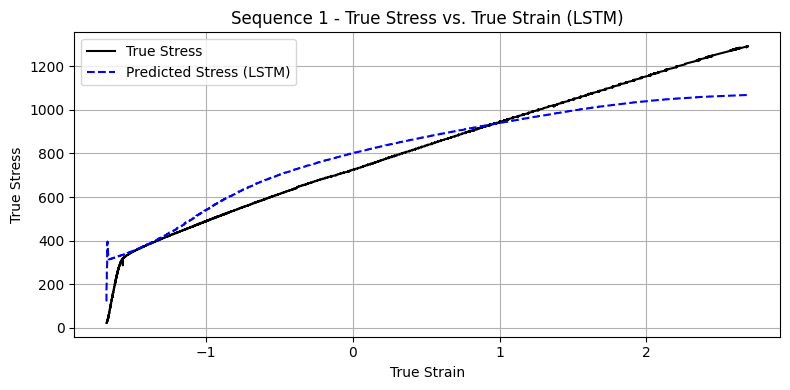

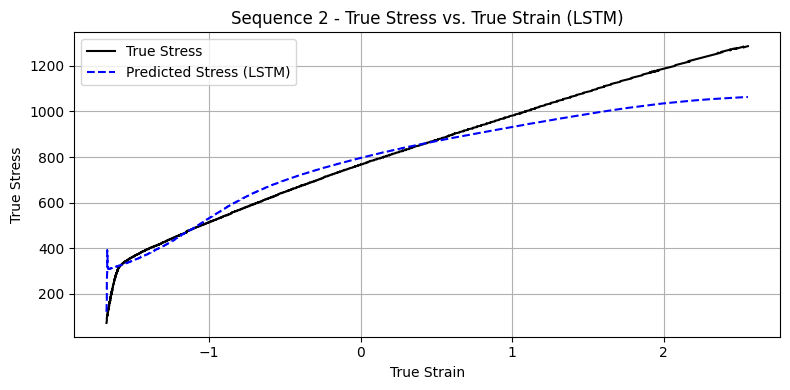

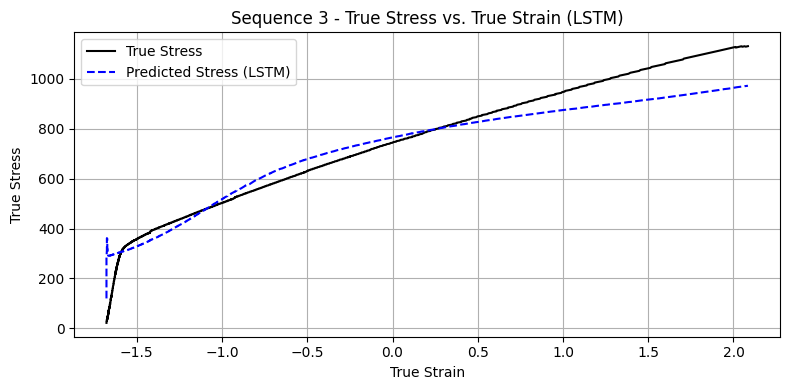

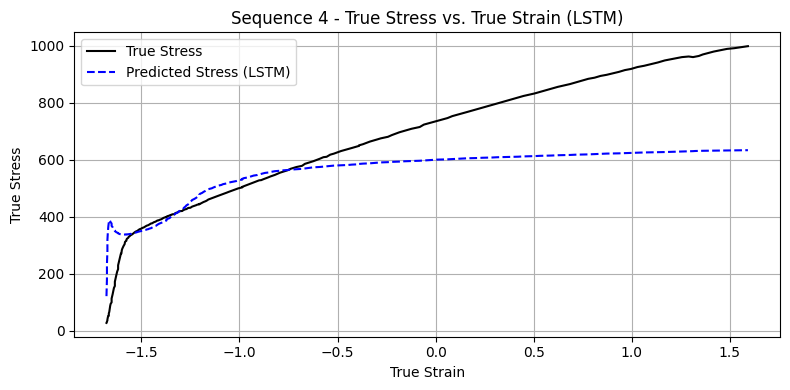

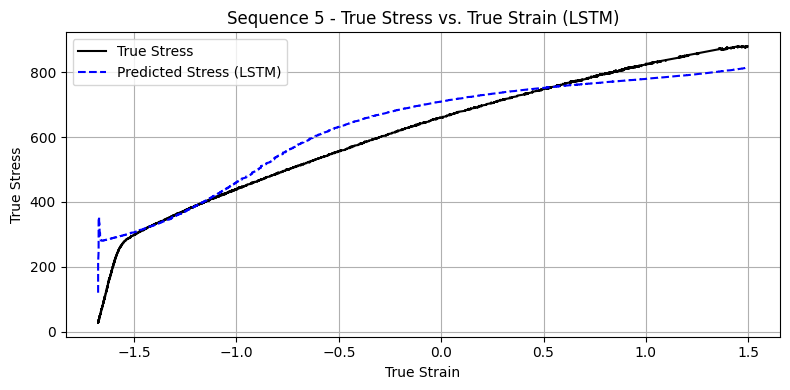

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load 
best_fold = np.argmin(validation_losses) + 1  # Indexing from 1
best_model_path = f"lstm_fold_{best_fold}_best.pt"

print(f"Loading best model from: {best_model_path}")
model = LSTMModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Inference
with torch.no_grad():
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)

    preds = model(X_tensor).cpu().numpy()
    y_true = y_tensor.cpu().numpy()

# Inverse
y_true_inv = y_scaler.inverse_transform(y_true.reshape(-1, 1)).reshape(y_true.shape)
preds_inv = y_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)

# Evaluation
mask = y_true != 0
mse = mean_squared_error(y_true_inv[mask], preds_inv[mask])
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv[mask], preds_inv[mask])
r2 = r2_score(y_true_inv[mask], preds_inv[mask])

print(f"\nBest Model Evaluation (Fold {best_fold}):")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


strain_sequences = X_data[:, :, 0]  
# Plot
for i in range(min(5, len(preds_inv))):
    valid_len = np.count_nonzero(y_true[i])
    strain_vals = strain_sequences[i][:valid_len]
    true_stress = y_true_inv[i][:valid_len]
    pred_stress = preds_inv[i][:valid_len]

    plt.figure(figsize=(8, 4))
    plt.plot(strain_vals, true_stress, label='True Stress', color='black')
    plt.plot(strain_vals, pred_stress, label='Predicted Stress (LSTM)', linestyle='--', color='blue')
    plt.title(f'Sequence {i+1} - True Stress vs. True Strain (LSTM)')
    plt.xlabel("True Strain")
    plt.ylabel("True Stress")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


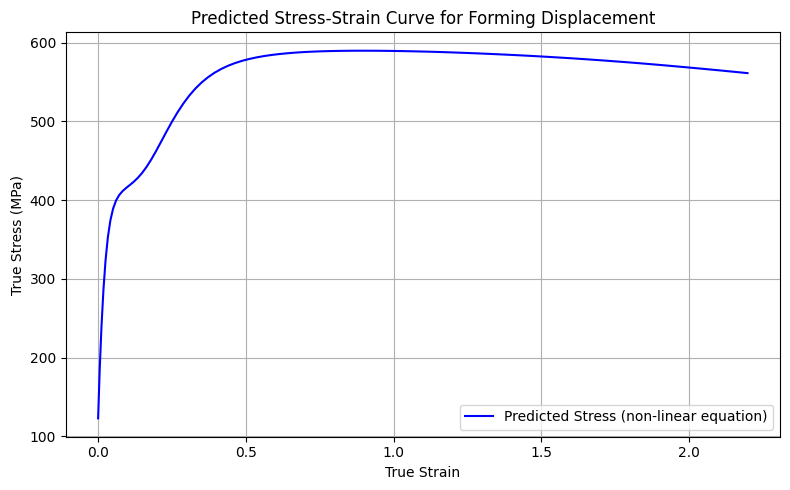

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt

L0 = 6.0  # Initial length 
T_fixed = 300  

# Time steps
t = np.linspace(0, 3, 100)

x = t**3 + 2*t**2 + t
dx_dt = 3*t**2 + 4*t + 1

# Strain and strain rate
strain = np.log(1 + x / L0)
strain_rate = dx_dt / (L0 + x)
temperature = np.full_like(strain, T_fixed)

# Prepare model
X_deploy = np.stack([strain, strain_rate, temperature], axis=1)

X_scaled = X_scaler.transform(X_deploy)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0).to(device) 

# Model prediction
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()[0]  # Shape: [seq_len]

# Inverse scales
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot stress-strain
plt.figure(figsize=(8, 5))
plt.plot(strain, y_pred_inv, label="Predicted Stress (non-linear equation)", color='blue')
plt.xlabel("True Strain")
plt.ylabel("True Stress (MPa)")
plt.title("Predicted Stress-Strain Curve for Forming Displacement")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
# For Naive Model (Final Model)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Training
final_model.eval()
with torch.no_grad():
    train_preds = final_model(X_train_tensor.to(device)).cpu().numpy()
    y_train_actual = y_scaler.inverse_transform(y_train.reshape(-1, 1))  # Reshaping for inverse transform
    train_preds = y_scaler.inverse_transform(train_preds.reshape(-1, 1))

# Validation
with torch.no_grad():
    val_preds = final_model(X_val_tensor.to(device)).cpu().numpy()
    y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1))
    val_preds = y_scaler.inverse_transform(val_preds.reshape(-1, 1))

# Test
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    y_test_actual = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    test_preds = y_scaler.inverse_transform(test_preds.reshape(-1, 1))

# Evaluation Metrics
def evaluate_metrics(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return mse, rmse, mae, r2

train_metrics = evaluate_metrics(y_train_actual, train_preds)
val_metrics = evaluate_metrics(y_val_actual, val_preds)
test_metrics = evaluate_metrics(y_test_actual, test_preds)

print("Naive Model Metrics:")
print(f"Training - MSE: {train_metrics[0]:.4f}, RMSE: {train_metrics[1]:.4f}, MAE: {train_metrics[2]:.4f}, R²: {train_metrics[3]:.4f}")
print(f"Validation - MSE: {val_metrics[0]:.4f}, RMSE: {val_metrics[1]:.4f}, MAE: {val_metrics[2]:.4f}, R²: {val_metrics[3]:.4f}")
print(f"Test - MSE: {test_metrics[0]:.4f}, RMSE: {test_metrics[1]:.4f}, MAE: {test_metrics[2]:.4f}, R²: {test_metrics[3]:.4f}")

#LSTM model and predictions
best_fold = np.argmin(validation_losses) + 1
best_model_path = f"lstm_fold_{best_fold}_best.pt"
print(f"Loading best model from: {best_model_path}")

model = LSTMModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

# LSTM Predictions
with torch.no_grad():
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)

    preds = model(X_tensor).cpu().numpy()
    y_true = y_tensor.cpu().numpy()

# Inverse transform
y_true_inv = y_scaler.inverse_transform(y_true.reshape(-1, 1)).reshape(y_true.shape)
preds_inv = y_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)

# Flatten the arrays
y_true_inv_flat = y_true_inv.flatten()
preds_inv_flat = preds_inv.flatten()

# Evaluation metrics
lstm_metrics = evaluate_metrics(y_true_inv_flat, preds_inv_flat)
print("\nLSTM Model Metrics:")
print(f"Test - MSE: {lstm_metrics[0]:.4f}, RMSE: {lstm_metrics[1]:.4f}, MAE: {lstm_metrics[2]:.4f}, R²: {lstm_metrics[3]:.4f}")


Naive Model Metrics:
Training - MSE: 819.0826, RMSE: 28.6196, MAE: 18.8854, R²: 0.9864
Validation - MSE: 826.3063, RMSE: 28.7455, MAE: 18.8831, R²: 0.9862
Test - MSE: 820.8415, RMSE: 28.6503, MAE: 18.8875, R²: 0.9863
Loading best model from: lstm_fold_4_best.pt

LSTM Model Metrics:
Test - MSE: 6293.1826, RMSE: 79.3296, MAE: 25.1442, R²: 0.8615


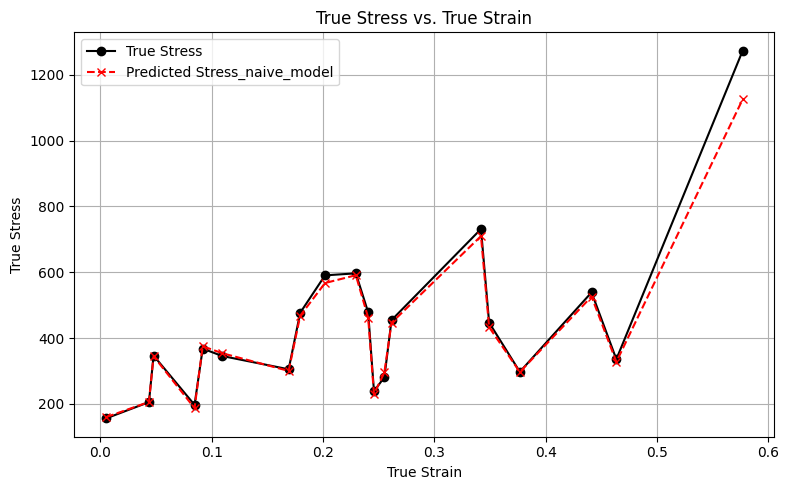

In [88]:
# Evaluation on Test Set
final_model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_scaled = final_model(X_test_tensor).cpu().numpy()

# Inverse transform to get actual stress
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

# Also inverse transform strain from scaled X_test
X_test_unscaled = X_scaler.inverse_transform(X_test)
strain = X_test_unscaled[:, 0]  # True Strain (first column)

# Sort by strain for consistency
sort_idx = np.argsort(strain)
strain_sorted = strain[sort_idx]
true_stress_sorted = y_true[sort_idx].flatten()
pred_stress_sorted = y_pred[sort_idx].flatten()

# Randomly select 20 indices from the sorted data
np.random.seed(42)  # For reproducibility
selected_indices = np.random.choice(len(strain_sorted), size=20, replace=False)

# Extract the selected points
strain_20 = strain_sorted[selected_indices]
true_stress_20 = true_stress_sorted[selected_indices]
pred_stress_20 = pred_stress_sorted[selected_indices]

# Sort the 20 points by strain for smooth plotting
sort_20 = np.argsort(strain_20)
strain_20 = strain_20[sort_20]
true_stress_20 = true_stress_20[sort_20]
pred_stress_20 = pred_stress_20[sort_20]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(strain_20, true_stress_20, 'o-', label="True Stress", color="black")
plt.plot(strain_20, pred_stress_20, 'x--', label="Predicted Stress_naive_model", color="red")
plt.xlabel("True Strain")
plt.ylabel("True Stress")
plt.title("True Stress vs. True Strain")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
